캐글의 자전거 대여 수요 예측 경연에서 사용된 학습 데이터 세트를 이용해 선형 회귀와 트리 기반 회귀를 비교

RMSLE를 사용

<생각할 것>

- 주말, 평일 중 평일이 많을 것이다

- 자전거 타기 좋은 날씨인 봄, 여름, 가을이 많을 것이다

- 출퇴근 시간인 7, 8, 17, 18가 많은 것이다

# 라이브러리 불러오기

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 데이터 불러오기

In [3]:
df = pd.read_csv('./data/bike_train.csv')

print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- datetime : hourly date + timestamp

- season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

- holiday: 1 = 토, 일요일의 주말을 제외한 국경일 들의 휴일, 0 = 휴일이 아닌 날

- workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일

- weather

    - 1 = 맑음, 약간 구름 낀 흐림
    
    - 2 = 안개, 안개 + 흐림
    
    - 3 = 가벼운 눈, 가벼운 비 + 천둥
    
    - 4 = 심한 눈 / 비, 천둥 / 번개 

- temp : 온도(섭씨)

- atemp : 체감온도(섭씨)

- humidity : 상대습도

- windspeed : 풍속

- casual : 사전에 등록되지 않는 사용자가 대여한 횟수

- registered : 사전에 등록된 사용자가 대여한 횟수

- count : 대여 횟수

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


=> 10886개의 row 데이터 중 Null 데이터가 없다

=> datetime은 년-월-일 시:분:초의 문자 형식이므로 데이터 처리가 필요하다

# EDA

'count' 그려보기

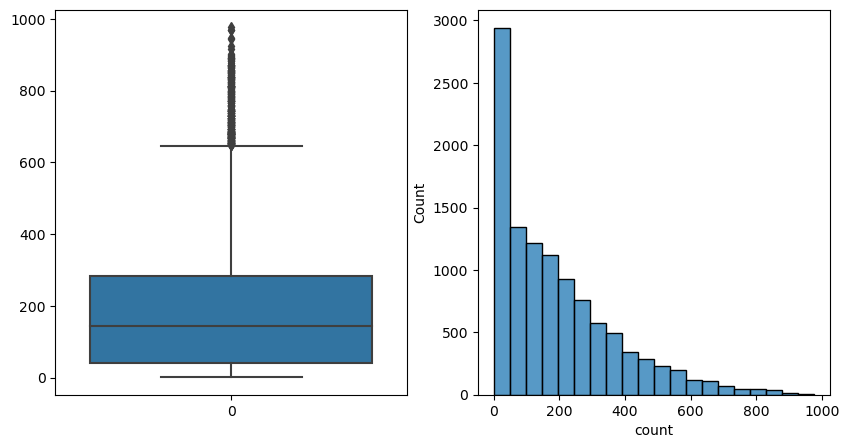

In [26]:
# 'count'를 박스 그래프와, 히스토그램 그려보기

fig, axs = plt.subplots(figsize = (10, 5), nrows = 1, ncols = 2)

sns.boxplot(df['count'], ax = axs[0]);
sns.histplot(df['count'], bins = 20, ax = axs[1]);

=> 분포도를 보면 타깃값인 'count'가 0 근처에 몰려 있다

    -> 즉, 분포가 왼쪽으로 많이 편향

=> 회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 한다

=> 현재 타깃값인 'count'는 정규분포를 따르지 않아 현재 타깃값을 그대로 사용해 모델링하면 좋은 성능이 나오기 어렵다

    -> 데이터 분포를 정규분포에 가깝게 만들기 위해 로그변환을 한다

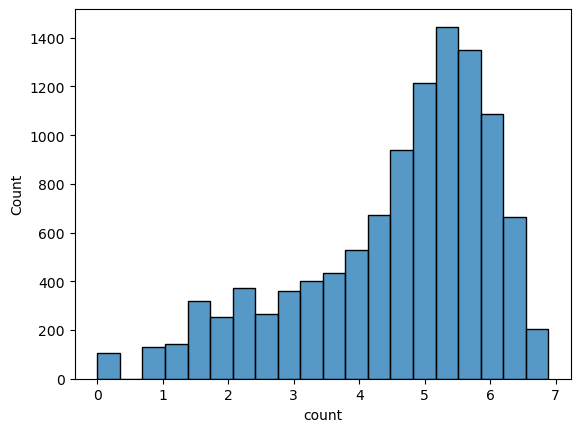

In [46]:
sns.histplot(np.log(df['count']), bins = 20);

=> 변환 전보다 정규분포에 가까워졌다

    -> 'count'를 그냥 사용하는 것보다 로그변환후 사용한다
    
=> 마지막에 'count'를 되돌리기 위해 지수변환을 사용한다

# 데이터 클렌징 및 가공과 데이터 시각화

## 'datetime' 문자열을 변경

In [28]:
# 문자열을 datetime 타입으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])

df['datetime'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10886 entries, 0 to 10885
Series name: datetime
Non-Null Count  Dtype         
--------------  -----         
10886 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 85.2 KB


In [31]:
# 'datetime'에서 년, 월, 일, 시간 추출 -> 판다스의 dt 이용

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [ ]:
# 'datetime'에서 년, 월, 일, 시간 추출하는 다른 방법 -> apply를 사용

# df['year'] = df.datetime.apply(lambda x : x.year)
# df['month'] = df.datetime.apply(lambda x : x.month)
# df['day'] = df.datetime.apply(lambda x : x.day)
# df['hour'] = df.datetime.apply(lambda x : x.hour)

casual : 사전에 등록되지 않은 사용자의 자전거 대여 횟수

registered : 사전에 등록된 사용자의 자전거 대여 횟수

count = casual + registered이므로 casual, registered는 제거

In [32]:
# 필요없는 col 제거

drop_cols = ['datetime', 'casual', 'registered']
df.drop(drop_cols, axis = 1, inplace = True)

## 주요 col별 Target값인 count의 분포 확인

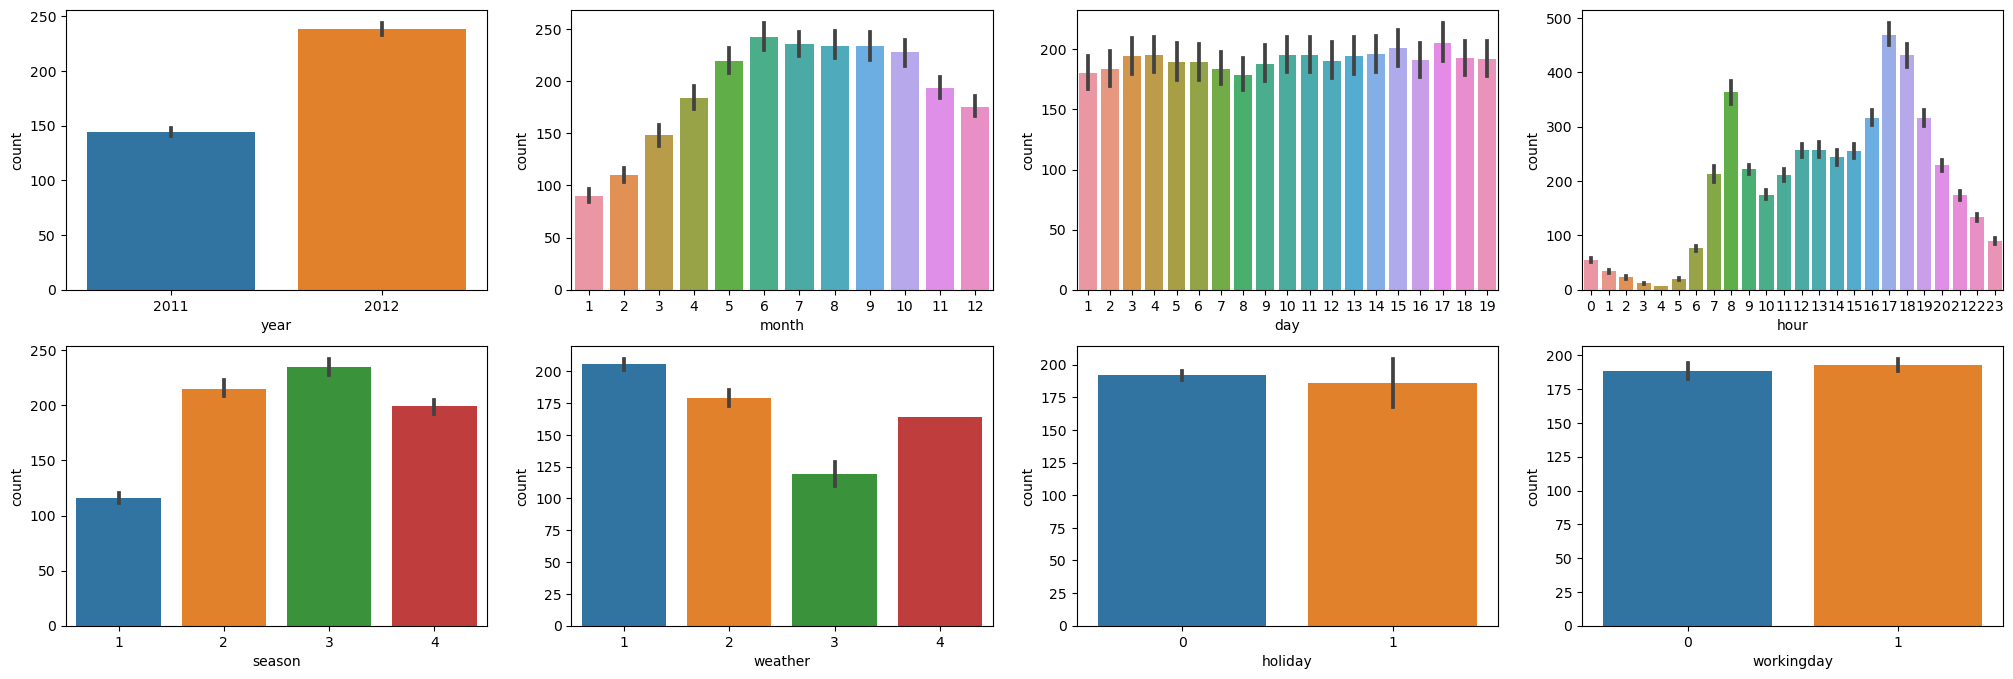

In [37]:
fig, axs = plt.subplots(figsize = (25, 8), ncols = 4, nrows = 2)

num_features = ['year', 'month', 'day', 'hour', 'season', 'weather', 'holiday', 'workingday']

# num_features에 있는 모든 col로 개별 컬럼값에 따른 'count'의 합을 barplot으로 시각화
for i, feature in enumerate(num_features):
    row = int(i / 4)
    col = i % 4
    
    # 시본의 barplot을 이용해 col에 따른 'count'의 합을 표현
    sns.barplot(x = feature, y = 'count', data = df, ax = axs[row][col])

=> 'year'별 'count'를 보면 2012년이 2011년보다 상대적으로 높다

    -> 특별한 의미보다는 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과라 볼 수 있다
    
=> 'month'의 경우 1, 2, 3월이 낮고, 6, 7, 8월이 높다

=> 'day'는 차이가 크지 않다

=> 'hour'의 경우 8(출근시간), 5, 6(퇴근시간)이 상대적으로 높다

=> 'season'의 경우 1(봄), 4(겨울)이 낮고 2(여름), 3(가을)이 높다

=> 'weather'의 경우 3, 4(비)가 낮고 1(맑음), 4(약간 안개)가 높다

=> 'holiday'는 0,  'workingday'는 1인  주중일 경가 높다

<Axes: >

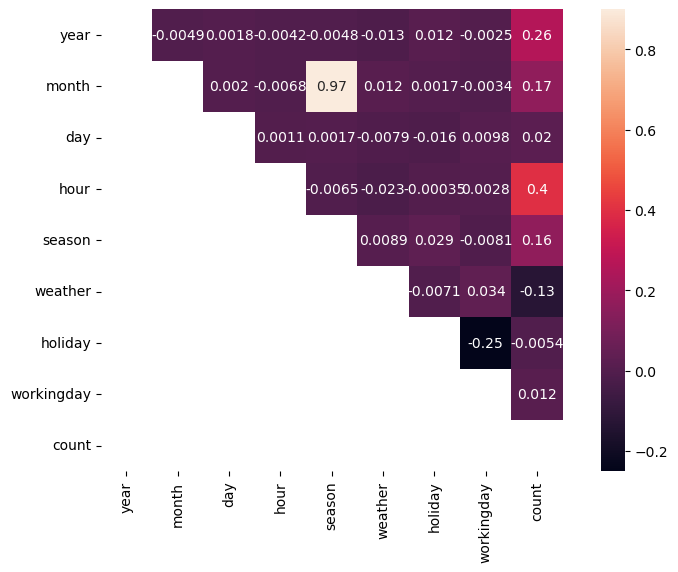

In [43]:
# 변수의 상관계수 확인

num_features = ['year', 'month', 'day', 'hour', 'season', 'weather', 'holiday', 'workingday', 'count']

mask = np.tril(np.ones_like(df[num_features].corr(), dtype=bool)) # 삼각 행렬 생성
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
sns.heatmap(df[num_features].corr(), mask = mask, vmax = .9, square = True, annot = True)

# 모델링

## 평가 지표 함수 구현

mean_squared_log_error()를 사용할 수 있지만 데이터 값의 크기에 따라 오버플로/언더플로가 발생할 수 있다

In [48]:
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE를 계산
# log1p()로 변환된 값은 다시 넘팜이의 expm1() 함수로 쉽게 원래의 스케일로 북원될 수 있다

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [49]:
# 사이킷런의 mean_square_erroe()를 이용해 RMSE 계산

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {:.3f}, RMSE : {:.3f}, MAE : {:.3f}'.format(rmsle_val, rmse_val, mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

### 먼저 기본 데이터로 LinearRegression로 회귀 예측

In [52]:
# feature, target 나누기

y_target = df['count']
X_features = df.drop(['count'], axis = 1, inplace = False)

# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

lr = LinearRegression() # 모델 생성
lr.fit(X_train, y_train) # 학습
pred = lr.predict(X_test) # 예측

evaluate_regr(y_test, pred) # 평가

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


실제 값과 예측 값이 어느 정도 차이가 나는지 확인

In [58]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame의 col으로 'count'와 예측값을 서로 비교할 수 있도록 생성
    res_df = pd.DataFrame(y_test.values, columns = ['real_count']) # 실제 값
    res_df['predict_count'] = np.round(pred) # 예측 값
    res_df['diff'] = np.abs(res_df['real_count'] - res_df['predict_count']) # 실제 값 - 예측 값
    
    # 예측 값과 실제 값이 가장 큰 데이터 순으로 출력
    print(res_df.sort_values('diff', ascending = False)[:n_tops]) # 'diff'로 데이터 정렬

get_top_error_data(y_test, pred)

      real_count  predict_count   diff
1618         890          322.0  568.0
3151         798          241.0  557.0
966          884          327.0  557.0
412          745          194.0  551.0
2817         856          310.0  546.0


### 'count'에 로그 변환 후

In [59]:
# 'count'값을 log1p로 로그 변환

y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)

lr = LinearRegression() # 모델 생성
lr.fit(X_train, y_train) # 학습
pred = lr.predict(X_test) # 예측

# 테스트 데이터 세트의 target값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test) # 'count' 지수 변환

# 예측값 역시 로드 변환된 target 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred) # 예측 값을 지수 변환

evaluate_regr(y_test_exp, pred_exp) # 평가

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


=> 이전 결과 'RMSLE : 1.165, RMSE : 140.900, MAE : 105.924'에서 RMSLE는 줄었지만, RMSE는 증가했다

    -> feature에 인코딩을 적용

<Axes: >

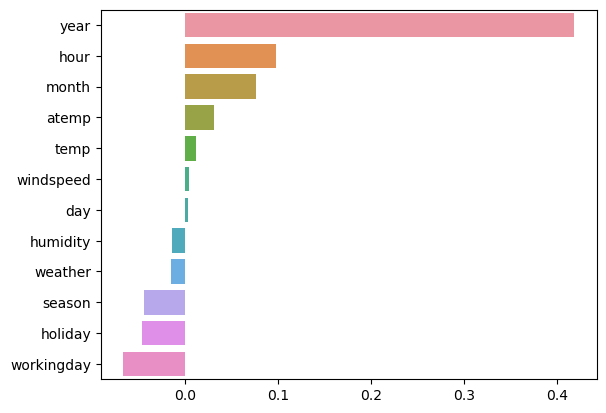

In [64]:
# 각 feature의 회귀 계숫값을 시각화

coef = pd.Series(lr.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

=> 'year', 'hour', 'month', 'season', 'holiday', 'workingday' feature의 회귀 계수 영향도가 상대적으로 높다

=> 'year', 'hour', 'month'등은 숫자 값으로 표현되었지만 이들은 모두 카테고리형 feature이다

숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다

    -> 선형 회귀에서는 이러한 feature 인코딩에 One-Hot-encoding을 적용

In [67]:
# get-dummies()를 이용해 One-Hot-Encoding을 처리
# 'year', 'month', 'day', 'hour'등의 feature들을 One-Hot-Encoding

X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'day', 'hour', 'season', 'weather', 'holiday', 'workingday'])

### 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습

In [73]:
# One-Hot-Encoding이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train) # 훈련
    pred = model.predict(X_test) # 에측
    if is_expm1: # 로그 변환했을 경우 지수 변환으로 변경
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
        
    print('\n###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred) # 평가
    
# 모델별로 평가 수행

lr = LinearRegression()
ridge = Ridge(alpha = 10)
lasso = Lasso(alpha = 0.01)

In [74]:
for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)


### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382

### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893

### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<Axes: >

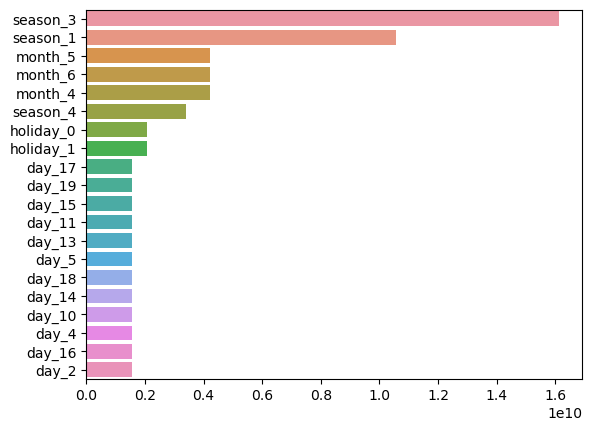

In [82]:
# One-Hot-Encoding된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화

coef = pd.Series(lr.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

=> one-Hot-Encoding을 통해 모델의 성능이 좋아졌다

### 회귀 트리를 이용한 회귀 예측 진행

In [85]:
# 랜덤 포레스트, GBM, XGBoost, LGBM 별로 평가 수행

rf = RandomForestRegressor(n_estimators = 500)
gbm = GradientBoostingRegressor(n_estimators = 500) 
xgb = XGBRegressor(n_estimators = 500)
lgbm = LGBMRegressor(n_estimators = 500)

for model in [rf, gbm, xgb, lgbm]:
    
    # xgb의 경우 dataframe이 입력될 경우 버전에 따라 오류 발생 가능 -> ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1 = True)


### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.207, MAE : 31.120

### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.334, MAE : 32.737

### XGBRegressor ###
RMSLE : 0.339, RMSE : 51.475, MAE : 31.357

### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


=> 선형회귀 모델보다 회귀 예측 성능이 개선